In [1]:
import collections
import datetime
import os
import sys

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn as sk
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas.tseries.holiday import USFederalHolidayCalendar

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

sys.path.append(os.path.abspath('../Data'))
import queries

# fix random seed for reproducibility
np.random.seed(5)

In [2]:
# server = 'VT1'
# schema = 'SRSHNKDIG'

# server = 'MA3'
# schema = 'SRSANBDIG'

server = 'VT3'
schema = 'WCS01600'

out_steps = 31

features = queries.get_profit_by_day(server, schema)

In [3]:
Models = collections.namedtuple('Models', ['MODEL', 'PARAMS'])
Model_Params = collections.namedtuple('Model_Params', ['LOSS', 'OPTIMIZER', 
                                      'EPOCHS', 'CALLBACKS', 'VERBOSE'])

MAX_EPOCHS = 40

In [4]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
               df=features,
               label_columns=None):
        
        self.df = df
        
        # Preprocess the data
        self.preprocess()

        # Work out the label column indices.
        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in
                                        enumerate(label_columns)}
        self.column_indices = {name: i for i, name in
                               enumerate(self.train_df.columns)}

        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
        
    def preprocess(self):
        # Date index
        self.date_index()
        # Add missing dates
        self.add_missing_dates()
        # Split into train, val, test
        self.train_val_test_split()
        # Normalize data
        self.normalize()
        
    def date_index(self):
        df = self.df
        
        # Combine individual date columns to single index
        df = df.rename(columns={'TYEAR':'YEAR', 'TMON':'MONTH', 'TDAY':'DAY'})
        df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']])
        df = df.drop(columns=['YEAR', 'MONTH', 'DAY'])
        df.set_index('DATE', inplace=True)
        
        self.df = df
    
    def add_missing_dates(self):
        df = self.df
        
        missing_dates = pd.date_range(start=df.index[0], end=df.index[-1]).difference(df.index)
        
        missing_dates_weekday = [date.weekday() for date in missing_dates]
        ten_pct = int(len(missing_dates_weekday) * 0.1)
        c = collections.Counter(missing_dates_weekday)
        common_missed_days = []
        for day, count in c.items():
            if count > ten_pct:
                common_missed_days.append(day)
            
        self.common_missed_days = common_missed_days
        
        n = len(missing_dates)
        m = len(df.columns)
        missing_dates_data = np.zeros((n,m))
        missing_dates_df = pd.DataFrame(missing_dates_data, index=missing_dates, columns=df.columns)
        dfs = [df, missing_dates_df]
        df = pd.concat(dfs)
        df['Date'] = df.index
        df = df.sort_values(by='Date')
        df.set_index('Date', inplace=True)
        
        self.df = df
        
    def train_val_test_split(self):
        df = self.df
        
        n = len(df)
        self.train_df = df[0:int(n*0.9)]
        self.val_df = df[int(n*0.9):]

        self.num_features = df.shape[1]
        
    def normalize(self):
        train_df = self.train_df
        val_df = self.val_df
        
        train_mean = train_df.mean()
        train_std = train_df.std()
        
        self.train_df = (train_df - train_mean) / train_std
        self.val_df = (val_df - train_mean) / train_std
        self.train_mean = train_mean
        self.train_std = train_std
        
    def split_window(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
            [labels[:, :, self.column_indices[name]] for name in self.label_columns],
            axis=-1)

        # Slicing doesn't preserve static shape information, so set the shapes
        # manually. This way the `tf.data.Datasets` are easier to inspect.
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels
    
    def plot(self, model=None, max_subplots=3):
        plot_col=self.label_columns[0]
        inputs, labels = self.example
        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))
        for n in range(max_n):
            plt.subplot(max_n, 1, n+1)
            plt.ylabel(f'{plot_col} [normed]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
                label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
                label_col_index = plot_col_index

            if label_col_index is None:
                continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
            if model is not None:
                predictions = model(inputs)
                plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                      marker='X', edgecolors='k', label='Predictions',
                      c='#ff7f0e', s=64)

            if n == 0:
                plt.legend()

        plt.xlabel('Time')
        
    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)

        ds = ds.map(self.split_window)

        return ds
    
    def compile_and_fit(self, model, window, patience=2):
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                        patience=patience,
                                                        mode='min')

        model.compile(loss=tf.losses.MeanSquaredError(),
                    optimizer=tf.optimizers.Adam(),
                    metrics=[tf.metrics.RootMeanSquaredError()])

        history = model.fit(window.train, epochs=MAX_EPOCHS,
                          validation_data=window.val,
                          callbacks=[early_stopping])
        return history

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)
    
    @property
    def output(self):
        return self.val_df.tail(self.label_width)
        
    @property
    def example(self):
        """Get and cache an example batch of `inputs, labels` for plotting."""
        result = getattr(self, '_example', None)
        if result is None:
            # No example batch was found, so get one from the `.train` dataset
            result = next(iter(self.train))
            # And cache it for next time
            self._example = result
        return result

    def __repr__(self):
        return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [5]:
def predict(model, window):
    output_data = np.array(window.output).reshape((1, out_steps, 1))
    labels = np.zeros(shape=(1, out_steps, 1))
    ds = tf.data.Dataset.from_tensor_slices([output_data, labels])
    
    date_list = [(datetime.datetime.today() + datetime.timedelta(days=x)).weekday() for x in range(1, window.label_width+1)]
    zero_indexes = np.where(np.isin(np.asarray(date_list), window.common_missed_days))
    
    model_output = model.predict(ds)
    index = window.column_indices[window.label_columns[0]]
    predictions_normed = model_output[model_output.shape[0] - 1, :, index]
    predictions = (predictions_normed * window.train_std[0]) + window.train_mean[0]
    for zero_index in zero_indexes:
        predictions[zero_index] = 0.0

    return predictions

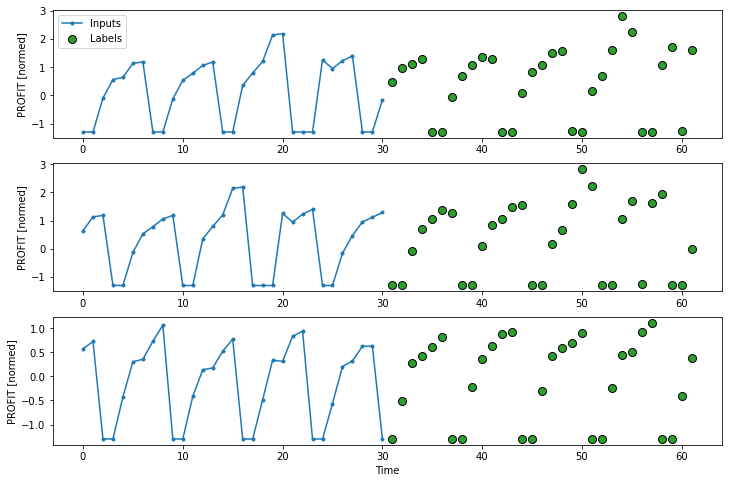

In [7]:
window = WindowGenerator(input_width=out_steps, label_width=out_steps, shift=out_steps,
                     label_columns=['PROFIT'])
window.plot()

Epoch 1/40
52/52 [==============================] - 3s 19ms/step - loss: 0.9229 - root_mean_squared_error: 0.9604 - val_loss: 0.7645 - val_root_mean_squared_error: 0.8744
Epoch 2/40
52/52 [==============================] - 1s 11ms/step - loss: 0.6411 - root_mean_squared_error: 0.8003 - val_loss: 0.5584 - val_root_mean_squared_error: 0.7472
Epoch 3/40
52/52 [==============================] - 1s 11ms/step - loss: 0.4801 - root_mean_squared_error: 0.6927 - val_loss: 0.4936 - val_root_mean_squared_error: 0.7026
Epoch 4/40
52/52 [==============================] - 1s 11ms/step - loss: 0.3594 - root_mean_squared_error: 0.5995 - val_loss: 0.4552 - val_root_mean_squared_error: 0.6747
Epoch 5/40
52/52 [==============================] - 1s 12ms/step - loss: 0.3174 - root_mean_squared_error: 0.5634 - val_loss: 0.4416 - val_root_mean_squared_error: 0.6645
Epoch 6/40
52/52 [==============================] - 1s 11ms/step - loss: 0.2907 - root_mean_squared_error: 0.5391 - val_loss: 0.4404 - val_root_m

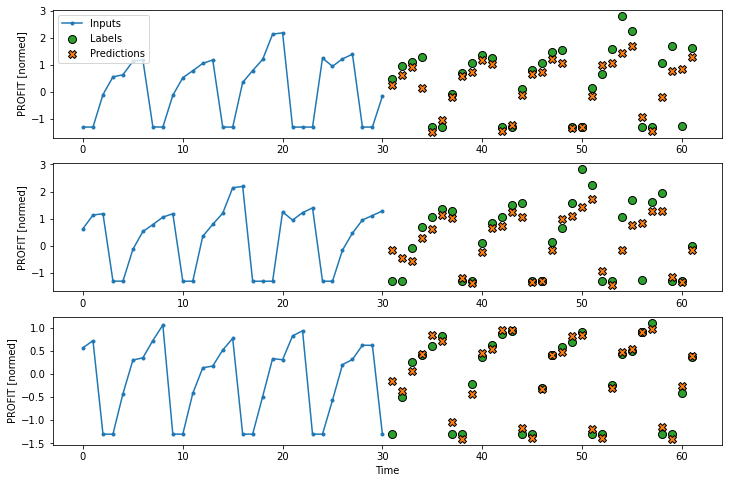

In [8]:
model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dropout(0.1),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

history = window.compile_and_fit(model, window)

window.plot(model)

In [9]:
predict(model, window)

array([153078.53 , 150470.47 , 142123.66 ,      0.   ,      0.   ,
       122155.95 , 128018.83 , 133241.05 , 132210.1  , 121467.91 ,
            0.   ,      0.   , 100954.84 , 111686.33 , 120879.14 ,
       124437.11 , 118645.2  ,      0.   ,      0.   ,  89777.586,
       101506.836, 114406.09 , 123427.164, 124973.305,      0.   ,
            0.   ,  84499.914,  91741.21 , 106825.234, 120333.45 ,
       128404.94 ], dtype=float32)